# Desenvolvimento de conversao arquivo h01 para netcdf
Este é um esqueleto para processamento dos arquivos csv/txt das plataformas, e conversão para netcdf, assim como preenchimento dos dados de informações (metadados). Os passos são os seguintes:
1. Abre arquivo JSON onde informações de configuração, da plataforma e dos arquivo netcdf estão armazenadas. Isso é necessário para flexibilizar o código e permitir reutilizacao do código. Isso é vantajoso quando várias estações com mesmo modelo de arquivo de saída são utilizadas.
2. Abertura do arquivo de imagem e conversão para base64. O arquivo netcdf não tem um tipo de variável adequado para armazenamento direto de arquivos binários. Ainda não esta fechado a melhor forma de armazenar esse tipo de dado dentro do netcdf, mas acho que converter o arquivo para baser64 (texto, muito utilizado em navegadores de internet) é um método razoavel. A vantagem dessa conversão é permitr armazenar os arquivos como texto simples, e fácil de recuperar. Esse formato ainda pode ser revisto.
3. Leitura do arquivo de dados, e varredura para alguns termos para confirmar que arquivo é da estação definida. Leitura das medidas em uma tabela Pandas
4. Criação do arquivo netcdf
5. Geração de metadados
6. Inserção dos dados no arquivo netcdf
7. Dump do arquivo para verificação
8. Verificação do padrão CF

Após desenvolvimento é possível exportar o codigo para .py e utilizar o codigo diretamente na linha de comando.

In [31]:
# Carrega bibliotecas de acordo com o necessario
import pandas as pd
import numpy as np
from datetime import datetime
import re
import os

from netCDF4 import Dataset,num2date, date2num
from datetime import timezone, timedelta

from netCDF4 import Dataset,num2date, date2num, stringtoarr
import json

from gbdhidro import utilconversor
from gbdhidro import utilcf
from gbdhidro.netcdfjson import NetCDFJSON
import base64

import argparse

from io import BytesIO
import logging

# Inicia logging
logger = logging.getLogger(__name__)


In [32]:
# Verifica se esta no jupyter. Isso altera o comportamento do codigo
IN_JUPYTER = utilconversor.isnotebook()
if IN_JUPYTER:
    DEBUG = True
    logging.basicConfig(level=logging.DEBUG)
    logger.info("Jupyter detectado. Alterando modo de operacao para DEBUG")
    # dentro do jupyter nao funciona o __FILE__. Então pegamos o diretorio atual
    # que funciona corretamente no contexto do jupyter, mas não fora
    here = os.getcwd()
else:
    DEBUG = False
    logging.basicConfig(level=logging.INFO)
    # Pega path absoluto para esse arquivo
    here = os.path.abspath(os.path.dirname(__file__))

INFO:__main__:Jupyter detectado. Alterando modo de operacao para DEBUG


In [33]:
if IN_JUPYTER:
    from PIL import Image
    %matplotlib inline
    import matplotlib.pyplot as plt

DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [34]:
# Codigo de erro utilizado no shell em caso de problema
ERROR_CODE = 1

if not IN_JUPYTER:
    parser = argparse.ArgumentParser(description='Converte arquivo para netCDF.')
    parser.add_argument("-i", "--input", help="nome do arquivo de entrada")
    parser.add_argument("-j", "--json", help="nome do arquivo de configuracao json")
    parser.add_argument("-o", "--output", help="nome do arquivo de saida. Se nao for informado eh gerado automaticamente")
    parser.add_argument("-d", "--directory", help="nome do diretorio de saida")
    args = parser.parse_args()
    
    OUTPUT_FOLDER = args.directory
    OUTPUT_FILE = args.output
    FILE_PATH = args.input
    JSON_FILE = args.json
    
    if FILE_PATH is None:
        parser.print_help()
        exit(ERROR_CODE)
        
    # TODO: encontrar uma forma para carreagr o arquivo automatico
    #if JSON_FILE is None:
    #    parser.print_help()
    #    exit(ERROR_CODE)

else:
    # esta dentro do jupyter, utiliza valores padroes para debug
    FILE_PATH = '../../input/h01/h01.txt'
    OUTPUT_FOLDER = '../../output'
    OUTPUT_FILE = None
    JSON_FILE = './h01.json'
    
# Arquivo com configuracao da estacao


In [35]:
# Abre arquivo json de configuração
with open(JSON_FILE, 'r') as fp:
    json_data = json.load(fp)

In [36]:
if IN_JUPYTER:
    display(json_data['station'])

{'name': 'h01',
 'latitude': -31.3726,
 'longitude': -52.6283,
 'altitude': 404.0,
 'image': 'h01.jpg',
 'name_match_string': ['E102 02 2012A'],
 'input_file_encoding': 'iso-8859-1'}

In [37]:
# Nome do arquivo de dados
STATION_NAME = json_data['station']['name']
# String com identificador utilizado para certificar que eh
# o arquivo da estao escolhida
STATION_NAME_MATCH = json_data['station']['name_match_string']
LATITUDE = json_data['station']['latitude']
LONGITUDE = json_data['station']['longitude']
ALTITUDE = json_data['station']['altitude']
IMAGE_FILE = json_data['station']['image']
#DATETIME_MATCH = json_data['station']['datetime_match_string']
#PRECIPITATION_MATCH = json_data['station']['precipitation_match_string']

# Seleciona encoding do arquivo
ENCODING = json_data['station']['input_file_encoding']
DECIMAL = ','
SEPARATOR = '\t'

In [38]:
logger.info("Conversao para estacao {}".format(STATION_NAME))

INFO:__main__:Conversao para estacao h01


In [39]:
# Le arquivo de imagem
with open(IMAGE_FILE, "rb") as image_file:
    image_base64 = utilcf.bin2base64(image_file.read())

In [40]:
# Le somente o cabecalho para ver se eh o arquivo procurado
fo = open(FILE_PATH, "r", encoding=ENCODING)
first_line = fo.readline()
second_line = fo.readline()
fo.close()

In [41]:
# Verifica se tem numero de serie correto
# Procura por alguns termos especifcos para verificar se o arquivo
# esta dentro do esperado
if utilconversor.find_matches(second_line,STATION_NAME_MATCH):
    logger.info('Processando estacao ' + STATION_NAME)
else:
    logger.info("Erro: não é arquivo da estacao " + STATION_NAME)


INFO:__main__:Processando estacao h01


In [42]:
# Le cabecalho da tabela
# Estou abrindo e fechando o arquivo pq fica mais facil gerenciar. Não é o mais eficiente
fo = open(FILE_PATH, "r", encoding=ENCODING)
# pula as primeiras 14 linhas
for i in range(14):
    fo.readline()
first_line = fo.readline()
fo.readline()
second_line = fo.readline()

first_line_sep = first_line.split()
second_line_sep = second_line.split()

header = ['Date', 'Time'] + first_line_sep
#for l1, l2 in zip(first_line_sep, second_line_sep):
#    header.append("{} {}".format(l1.strip(),l2.strip()))

fo.close()
print(header)

['Date', 'Time', 'Precipitação', 'Sedimentos', 'Nível', 'Vazão', 'Bateria']


In [43]:
# Extrai dados da aquisicao
table = pd.read_csv(FILE_PATH, delim_whitespace=True, skiprows=18, verbose=False, na_filter=True, header=None, encoding=ENCODING, decimal=DECIMAL, warn_bad_lines=True, dtype=str)

table.columns = header

if IN_JUPYTER:
    display(table)

,Date,Time,Precipitação,Sedimentos,Nível,Vazão,Bateria
0,04/03/2020,10:00:20,"0,000","0,000","95,003","201,870","13,226"
1,04/03/2020,10:10:20,"0,000","0,000","95,003","201,870","13,352"
2,04/03/2020,10:20:20,"0,000","0,000","95,003","201,870","13,278"
3,04/03/2020,10:30:20,"0,000","0,000","95,003","201,870","13,278"
4,04/03/2020,10:40:20,"0,000","0,000","87,643","178,194","12,947"
...,...,...,...,...,...,...,...
3766,Reinício,de,medidas,em,30/03/2020,11:25:06,NaN
3767,30/03/2020,11:25:06,"0,000","0,000","95,003","178,194","13,110"
3768,Medidas,efetuadas,até,30/03/2020,11:25:06,NaN,NaN
3769,Reinício,de,medidas,em,30/03/2020,11:25:24,NaN


In [44]:
# Procura por colunas de dados e gera erro se não encontrar  
#'Precipitação', 'Sedimentos', 'Nível', 'Vazão', 'Bateria']
var_list = {
        'date': {'match':['Date'], 'pandas_col': None},
        'time': {'match':['Time'], 'pandas_col': None},
        'precipitation': {'netcdf_var':'precipitation', 'match':['Precipitação'], 'pandas_col': None},
        'sediment': {'netcdf_var':'sediment', 'match':['Sedimentos'], 'pandas_col': None},
        'level': {'netcdf_var':'level', 'match':['Nível'], 'pandas_col': None},
        'battery': {'netcdf_var':'battery', 'match':['Bateria'], 'pandas_col': None}
    }


for key, value in var_list.items():
    found = False
    for column in table.columns:
        if utilconversor.find_matches(column,value['match']):
            value['pandas_col'] = column
            found = True
            break
    if not found:
        logger.error('Erro, nao foi encontrada coluna {}'.format(key))
        exit(ERROR_CODE)

In [45]:
# Filtra linhas incorretas
bad_rows = []
for index, row in table.iterrows():
    date = row[var_list["date"]["pandas_col"]]
    time = row[var_list["time"]["pandas_col"]]
    # Apaga estes elementos da lista pois ja foram utilizados
    # evita atrapalhar algm codigo mais adiante
    #del var_list['date']
    #del var_list['time']
    
    date_str = '{} {}'.format(date, time)
    try:
        date_time = pd.to_datetime(date_str, format='%d/%m/%Y %H:%M:%S')
    except:
        bad_rows.append(index)

if bad_rows:
    logger.info('Foram removidas {} linhas com dados invalidos'.format(len(bad_rows)))
    table = table.drop(bad_rows)

INFO:__main__:Foram removidas 16 linhas com dados invalidos


In [46]:
date = table[var_list["date"]["pandas_col"]]
time = table[var_list["time"]["pandas_col"]]
# Apaga estes elementos da lista pois ja foram utilizados
# evita atrapalhar algm codigo mais adiante
del var_list['date']
del var_list['time']

date_str = date.str.cat(time, sep=" ")
date_time = pd.to_datetime(date_str, format='%d/%m/%Y %H:%M:%S')

if IN_JUPYTER:
    display(date_time)

0      2020-03-04 10:00:20
1      2020-03-04 10:10:20
2      2020-03-04 10:20:20
3      2020-03-04 10:30:20
4      2020-03-04 10:40:20
               ...        
3762   2020-03-30 11:00:57
3763   2020-03-30 11:10:57
3764   2020-03-30 11:20:57
3767   2020-03-30 11:25:06
3770   2020-03-30 11:25:24
Name: Date, Length: 3755, dtype: datetime64[ns]

In [47]:
# Processa datetime para incluir timezone
#date_str = table[date_time_col]
#date_time = pd.to_datetime(date_str, format='%d/%m/%y %I:%M:%S %p')
# extrai informacao de gmt
#gmt_hour_offset, gmt_minute_offset = utilconversor.get_gmt_offset(date_time.name)
# TODO: Como converte para UTC essa estacao?
gmt_hour_offset = -3
gmt_minute_offset = 0
tzinfo=timezone(timedelta(hours=gmt_hour_offset, minutes=gmt_minute_offset))
# gera os indices com informacao de fuso horarios incluido
index = date_time.dt.tz_localize(tzinfo)
# converte para UTC
index_utc = index.dt.tz_convert('UTC')
first_day_str = utilcf.datetime2str(index_utc.iloc[0])
last_day_str = utilcf.datetime2str(index_utc.iloc[-1])
logger.info("Inicio e fim de medidas em UTC: {} - {}".format(first_day_str, last_day_str))

INFO:__main__:Inicio e fim de medidas em UTC: 20200304T130020Z - 20200330T142524Z


In [48]:
# Encontra coluna com chuva
#precipitation = table[cols['rain']['col']]

#if IN_JUPYTER:
#    display(precipitation)

In [49]:
# Gera nome de arquivo de saida
#file_name = '{}_{}_{}.nc'.format(STATION_NAME, first_day_str, last_day_str)
#logger.info("Nome de arquivo de saida: {}".format(file_name))

if OUTPUT_FILE is None:
    file_name = '{}_{}_{}.nc'.format(STATION_NAME, first_day_str, last_day_str)
else:
    file_name = OUTPUT_FILE

if OUTPUT_FOLDER is None:
    nc_file_path = file_name
else:
    nc_file_path = os.path.join(OUTPUT_FOLDER, file_name)

logger.info("Nome de arquivo de saida: {}".format(file_name))



INFO:__main__:Nome de arquivo de saida: h01_20200304T130020Z_20200330T142524Z.nc


In [50]:
# Convert string to floats
table[var_list['precipitation']['pandas_col']] = table[var_list['precipitation']["pandas_col"]].str.replace(',', '').astype(float)
table[var_list['sediment']['pandas_col']] = table[var_list['sediment']["pandas_col"]].str.replace(',', '').astype(float)
table[var_list['level']['pandas_col']] = table[var_list['level']["pandas_col"]].str.replace(',', '').astype(float)
table[var_list['battery']['pandas_col']] = table[var_list['battery']["pandas_col"]].str.replace(',', '').astype(float)


## Geracao de arquivo netCDF

In [51]:
#nc_file_path = os.path.join(OUTPUT_FOLDER, file_name)
# Cria arquivo netCDF
nc_file = NetCDFJSON()
nc_file.write(nc_file_path)
# Le arquivo json com configuracao da estrutura do netcdf
nc_file.load_json(JSON_FILE)
nc_file.create_from_json()

# pega handlers para dimensoes
timeDim = nc_file.get_dimension('time')
nameDim = nc_file.get_dimension('name_strlen')
# pega handlers para variaveis
time = nc_file.get_variable('time')
time_bnds = nc_file.get_variable('time_bnds')
lat = nc_file.get_variable('lat')
lon = nc_file.get_variable('lon')
alt = nc_file.get_variable('alt')
station_name = nc_file.get_variable('station_name')
#precip = nc_file.get_variable('precipitation')
station_image = nc_file.get_variable('station_image')

# Recupera qual o valor uilizado para valores que estao faltando
#FILL_VALUE = precip._FillValue

In [52]:
# Insere lista de variaveis no netcdf
for key, value in var_list.items():
    nc_var = nc_file.get_variable(value['netcdf_var'])
    FILL_VALUE = nc_var._FillValue
    data_var = table[value['pandas_col']]
    data_var = data_var.replace(np.nan, FILL_VALUE)
    data_var = data_var.to_numpy()
    nc_var[:] = data_var
    


In [53]:
# Substitui Nan por FILL_VALUE
#precipitation = precipitation.replace(np.nan, FILL_VALUE)

# Seta variaveis
nc_time = index_utc.to_numpy()
nc_time = date2num(nc_time,units=time.units,calendar=time.calendar)
# Como a precipitacao e o acumulado entre a ultima medida e a atual
# é necessario informar isso atraves dos bounds de tempo, ou seja,
# os valores inferioes e superiores respectivos ao limite do eixo de temp0
# O bound superior e o mesmo que o horario da medids
nc_superior_bound_time = nc_time
# bound inferior e o horario da ultima medida
nc_inferior_bound_time = np.roll(nc_superior_bound_time,1)
# a primeira medida não tem medida anterior, por isso seta para o mesmo valor
nc_inferior_bound_time[0] = nc_superior_bound_time[0]
# combina bound inferior com bound superior
bnds = np.stack((nc_inferior_bound_time, nc_superior_bound_time), axis=-1)

#nc_serie = precipitation.to_numpy()

nc_station_name = STATION_NAME
latitude = LATITUDE
longitude = LONGITUDE
altitude = ALTITUDE

lat[:] = np.array([latitude])
lon[:] = np.array([longitude])
alt[:] = np.array([altitude])

time[:] = nc_time
time_bnds[:] = bnds

#precip[:] = np.array(nc_serie)

station_name[:] = stringtoarr(nc_station_name, nameDim.size)
station_image[:] = stringtoarr(image_base64, len(image_base64))
station_image.file_name = IMAGE_FILE

In [54]:
# Faz processamento para metadados
# Processa os dados ja convertidos para facilitar reutilizar o codigo depois

# min max lat e lon
min_lat = np.amin(lat)
max_lat = np.amax(lat)
min_lon = np.amin(lon)
max_lon = np.amax(lon)

# time duration
min_time = num2date(np.amin(time), units=time.units, calendar=time.calendar)
max_time = num2date(np.amax(time), units=time.units, calendar=time.calendar)
min_time_str = utilcf.datetime2str(min_time)
max_time_str = utilcf.datetime2str(max_time)
time_delta = max_time - min_time
time_delta_str = utilcf.timedelta2str(time_delta)

# time resolution
time1 = num2date(time[1], units=time.units, calendar=time.calendar)
time0 = num2date(time[0], units=time.units, calendar=time.calendar)
time_resolution = time1 - time0
time_resolution_str = utilcf.timedelta2str(time_resolution)


logger.info('Min/Max latitude: {}/{}'.format(min_lat,max_lat))
logger.info('Min/Max longitude: {}/{}'.format(min_lon,max_lon))
logger.info('Min/Max datetime: {}/{}'.format(min_time_str,max_time_str))
logger.info('Time duration:{}'.format(time_delta_str))
logger.info('Time resolution:{}'.format(time_resolution_str))


INFO:__main__:Min/Max latitude: -31.372600555419922/-31.372600555419922
INFO:__main__:Min/Max longitude: -52.628299713134766/-52.628299713134766
INFO:__main__:Min/Max datetime: 20200304T130020Z/20200330T142524Z
INFO:__main__:Time duration:P26DT01H25M04S
INFO:__main__:Time resolution:PT10MS


In [55]:
# Atualiza metadados
nc_file.rootgrp.geospatial_lat_min = min_lat
nc_file.rootgrp.geospatial_lat_max = max_lat
nc_file.rootgrp.geospatial_lon_min = min_lon
nc_file.rootgrp.geospatial_lon_max = max_lon
nc_file.rootgrp.time_coverage_start = min_time_str
nc_file.rootgrp.time_coverage_end = max_time_str
nc_file.rootgrp.time_coverage_duration = time_delta_str
nc_file.rootgrp.time_coverage_resolution = time_resolution_str
nc_file.rootgrp.id = file_name
nc_file.rootgrp.date_created = utilcf.datetime2str(datetime.now(timezone.utc))

In [56]:
#nc_file.rootgrp

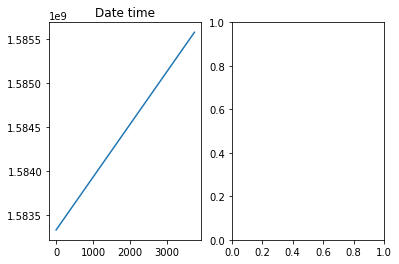

h01.jpg


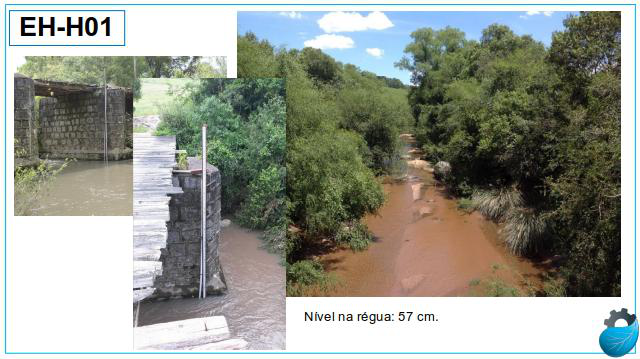

In [57]:
# Visualiza dados para confirma se esta tudo ok.
# Date time deve ser linear, sem quebras abruptas
if IN_JUPYTER:
    fig, (ax0, ax1) = plt.subplots(ncols=2)
    ax0.plot(time[:])
    ax0.set_title('Date time')
    #ax1.plot(precip[:])
    #ax1.set_title('Variavel')
    plt.show() 

    # Mostra imagem
    image = utilcf.base642bin(station_image[:])
    print(station_image.file_name)
    im = Image.open(image)
    display(im)

In [58]:
# Fecha e salva arquivo
nc_file.close()

## Dump do arquivo nc

In [59]:
# Apresenta o dump do arquivo netcdf
# Precisa instalar: sudo apt install netcdf-bin 
if IN_JUPYTER:
    cmd = '"' + nc_file_path + '"'
    !ncdump {  cmd }

netcdf h01_20200304T130020Z_20200330T142524Z {
dimensions:
	time = UNLIMITED ; // (3755 currently)
	name_strlen = 23 ;
	image_size = UNLIMITED ; // (61840 currently)
	nv = 2 ;
variables:
	double time(time) ;
		time:long_name = "time of measurement" ;
		time:standard_name = "time" ;
		time:units = "seconds since 1970-01-01 00:00:00 UTC" ;
		time:bounds = "time_bnds" ;
		time:axis = "T" ;
		time:calendar = "gregorian" ;
		time:comment = "" ;
	double time_bnds(time, nv) ;
	float lat ;
		lat:_FillValue = -999.9f ;
		lat:long_name = "station latitude" ;
		lat:standard_name = "latitude" ;
		lat:units = "degrees_north" ;
		lat:axis = "Y" ;
		lat:valid_min = -90.f ;
		lat:valid_max = 90.f ;
		lat:comment = "" ;
	float lon ;
		lon:_FillValue = -999.9f ;
		lon:long_name = "station longitude" ;
		lon:standard_name = "longitude" ;
		lon:units = "degrees_east" ;
		lon:axis = "X" ;
		lon:valid_min = -180.f ;
		lon:valid_max = 180.f ;
		lon:comment = "" ;
	float alt ;
		alt:_FillValue = -999.9f ;
		a

  1583458820, 1583459420,
  1583459420, 1583460020,
  1583460020, 1583460620,
  1583460620, 1583461220,
  1583461220, 1583461820,
  1583461820, 1583462420,
  1583462420, 1583463020,
  1583463020, 1583463620,
  1583463620, 1583464220,
  1583464220, 1583464820,
  1583464820, 1583465420,
  1583465420, 1583466020,
  1583466020, 1583466620,
  1583466620, 1583467220,
  1583467220, 1583467820,
  1583467820, 1583468420,
  1583468420, 1583469020,
  1583469020, 1583469620,
  1583469620, 1583470220,
  1583470220, 1583470820,
  1583470820, 1583471420,
  1583471420, 1583472020,
  1583472020, 1583472620,
  1583472620, 1583473220,
  1583473220, 1583473820,
  1583473820, 1583474420,
  1583474420, 1583475020,
  1583475020, 1583475620,
  1583475620, 1583476220,
  1583476220, 1583476820,
  1583476820, 1583477420,
  1583477420, 1583478020,
  1583478020, 1583478620,
  1583478620, 1583479220,
  1583479220, 1583479820,
  1583479820, 1583480420,
  1583480420, 1583481020,
  1583481020, 1583481620,
  1583481620

  1583941220, 1583941820,
  1583941820, 1583942420,
  1583942420, 1583943020,
  1583943020, 1583943620,
  1583943620, 1583944220,
  1583944220, 1583944820,
  1583944820, 1583945420,
  1583945420, 1583946020,
  1583946020, 1583946620,
  1583946620, 1583947220,
  1583947220, 1583947820,
  1583947820, 1583948420,
  1583948420, 1583949020,
  1583949020, 1583949620,
  1583949620, 1583950220,
  1583950220, 1583950820,
  1583950820, 1583951420,
  1583951420, 1583952020,
  1583952020, 1583952620,
  1583952620, 1583953220,
  1583953220, 1583953820,
  1583953820, 1583954420,
  1583954420, 1583955020,
  1583955020, 1583955620,
  1583955620, 1583956220,
  1583956220, 1583956820,
  1583956820, 1583957420,
  1583957420, 1583958020,
  1583958020, 1583958620,
  1583958620, 1583959220,
  1583959220, 1583959820,
  1583959820, 1583960420,
  1583960420, 1583961020,
  1583961020, 1583961620,
  1583961620, 1583962220,
  1583962220, 1583962820,
  1583962820, 1583963420,
  1583963420, 1583964020,
  1583964020

  1584421820, 1584422420,
  1584422420, 1584423020,
  1584423020, 1584423620,
  1584423620, 1584424220,
  1584424220, 1584424820,
  1584424820, 1584425420,
  1584425420, 1584426020,
  1584426020, 1584426620,
  1584426620, 1584427220,
  1584427220, 1584427820,
  1584427820, 1584428420,
  1584428420, 1584429020,
  1584429020, 1584429620,
  1584429620, 1584430220,
  1584430220, 1584430820,
  1584430820, 1584431420,
  1584431420, 1584432020,
  1584432020, 1584432620,
  1584432620, 1584433220,
  1584433220, 1584433820,
  1584433820, 1584434420,
  1584434420, 1584435020,
  1584435020, 1584435620,
  1584435620, 1584436220,
  1584436220, 1584436820,
  1584436820, 1584437420,
  1584437420, 1584438020,
  1584438020, 1584438620,
  1584438620, 1584439220,
  1584439220, 1584439820,
  1584439820, 1584440420,
  1584440420, 1584441020,
  1584441020, 1584441620,
  1584441620, 1584442220,
  1584442220, 1584442820,
  1584442820, 1584443420,
  1584443420, 1584444020,
  1584444020, 1584444620,
  1584444620

  1584930620, 1584931220,
  1584931220, 1584931820,
  1584931820, 1584932420,
  1584932420, 1584933020,
  1584933020, 1584933620,
  1584933620, 1584934220,
  1584934220, 1584934820,
  1584934820, 1584935420,
  1584935420, 1584936020,
  1584936020, 1584936620,
  1584936620, 1584937220,
  1584937220, 1584937820,
  1584937820, 1584938420,
  1584938420, 1584939020,
  1584939020, 1584939620,
  1584939620, 1584940220,
  1584940220, 1584940820,
  1584940820, 1584941420,
  1584941420, 1584942020,
  1584942020, 1584942620,
  1584942620, 1584943220,
  1584943220, 1584943820,
  1584943820, 1584944420,
  1584944420, 1584945020,
  1584945020, 1584945620,
  1584945620, 1584946220,
  1584946220, 1584946820,
  1584946820, 1584947420,
  1584947420, 1584948020,
  1584948020, 1584948620,
  1584948620, 1584949220,
  1584949220, 1584949820,
  1584949820, 1584950420,
  1584950420, 1584951020,
  1584951020, 1584951620,
  1584951620, 1584952220,
  1584952220, 1584952820,
  1584952820, 1584953420,
  1584953420

  1585460448, 1585461048,
  1585461048, 1585461648,
  1585461648, 1585462248,
  1585462248, 1585462848,
  1585462848, 1585463448,
  1585463448, 1585464048,
  1585464048, 1585464648,
  1585464648, 1585465248,
  1585465248, 1585465848,
  1585465848, 1585466448,
  1585466448, 1585467048,
  1585467048, 1585467648,
  1585467648, 1585468248,
  1585468248, 1585468848,
  1585468848, 1585469448,
  1585469448, 1585470048,
  1585470048, 1585470648,
  1585470648, 1585471248,
  1585471248, 1585471848,
  1585471848, 1585472448,
  1585472448, 1585473048,
  1585473048, 1585473648,
  1585473648, 1585474248,
  1585474248, 1585474848,
  1585474848, 1585475448,
  1585475448, 1585476048,
  1585476048, 1585476648,
  1585476648, 1585477248,
  1585477248, 1585477848,
  1585477848, 1585478448,
  1585478448, 1585479048,
  1585479048, 1585479648,
  1585479648, 1585480248,
  1585480248, 1585480848,
  1585480848, 1585481448,
  1585481448, 1585482048,
  1585482048, 1585482648,
  1585482648, 1585483248,
  1585483248

    72922, 72922, 72922, 72922, 72922, 72922, 72922, 72922, 72922, 72922, 
    72922, 72922, 72922, 72922, 72922, 72922, 72922, 72922, 72922, 72922, 
    72922, 72922, 72922, 72922, 72922, 72922, 72922, 72922, 72922, 72922, 
    72922, 72922, 72922, 72922, 72922, 72922, 72922, 80282, 80282, 80282, 
    80282, 80282, 80282, 80282, 80282, 80282, 87643, 87643, 95003, 87643, 
    95003, 87643, 87643, 87643, 87643, 95003, 95003, 95003, 95003, 95003, 
    87643, 95003, 87643, 95003, 95003, 95003, 95003, 95003, 95003, 95003, 
    95003, 95003, 95003, 95003, 95003, 95003, 95003, 95003, 95003, 95003, 
    87643, 87643, 87643, 87643, 87643, 87643, 87643, 87643, 87643, 80282, 
    80282, 80282, 80282, 80282, 80282, 80282, 80282, 80282, 80282, 80282, 
    80282, 80282, 80282, 80282, 80282, 80282, 80282, 80282, 80282, 80282, 
    80282, 80282, 80282, 80282, 80282, 80282, 80282, 80282, 80282, 80282, 
    80282, 80282, 80282, 80282, 80282, 80282, 80282, 80282, 80282, 80282, 
    80282, 80282, 80282, 

## Verifica se arquivo .nc atende o CF Standard

In [60]:
# Verifica compatibilidade com CF
# Precisa instalar pip install cfchecker 
# site: https://pypi.org/project/cfchecker/
if IN_JUPYTER:
    CF_VERSION = '1.7'
    cmd = '-v ' + CF_VERSION + ' ' + '"' + nc_file_path + '"'
    !cfchecks {cmd}

CHECKING NetCDF FILE: ../../output/h01_20200304T130020Z_20200330T142524Z.nc
Using CF Checker Version 4.0.0
Checking against CF Version CF-1.7
Using Standard Name Table Version 72 (2020-03-10T11:52:02Z)
Using Area Type Table Version 9 (07 August 2018)
Using Standardized Region Name Table Version 4 (18 December 2018)


------------------
Checking variable: time
------------------

------------------
Checking variable: time_bnds
------------------

------------------
Checking variable: lat
------------------

------------------
Checking variable: lon
------------------

------------------
Checking variable: alt
------------------

------------------
Checking variable: station_name
------------------

------------------
Checking variable: station_image
------------------

------------------
Checking variable: sediment
------------------
ERROR: (3.3): Invalid syntax for 'standard_name' attribute: 'sediment_??'
ERROR: (3.1): Invalid units: mv

------------------
Checking variable: level
----